## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [46]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [2]:
# Cells for you to work and document as necessary - 
# definitely feel free to add more cells as you need

## EDA

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
ID           84534 non-null int64
Promotion    84534 non-null object
purchase     84534 non-null int64
V1           84534 non-null int64
V2           84534 non-null float64
V3           84534 non-null float64
V4           84534 non-null int64
V5           84534 non-null int64
V6           84534 non-null int64
V7           84534 non-null int64
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [4]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


### V2

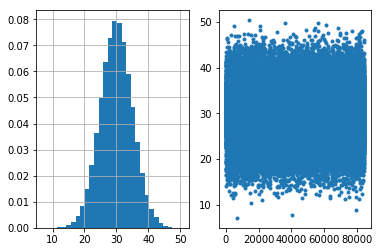

In [5]:
plt.subplot(1,2,1)
train_data.V2.hist(bins=30, density=True)
plt.subplot(1,2,2)
train_data.V2.plot(style='.')

That looks like Gaussian data.

In [6]:
train_data.V2.describe()

count    84534.000000
mean        29.973600
std          5.010626
min          7.104007
25%         26.591501
50%         29.979744
75%         33.344593
max         50.375913
Name: V2, dtype: float64

### V3

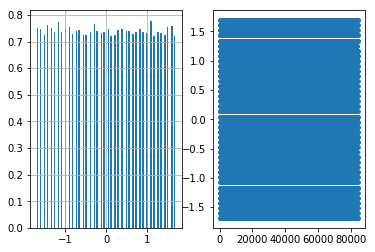

In [7]:
plt.subplot(1,2,1)
train_data.V3.hist(bins=100, density=True)
plt.subplot(1,2,2)
train_data.V3.plot(style='.')

That doesn't look like Gaussian data...

In [8]:
v3_values = train_data.V3.sort_values().unique()
v3_values

array([-1.6845501 , -1.5979723 , -1.5113946 , -1.4248168 , -1.338239  ,
       -1.2516612 , -1.1650834 , -1.0785056 , -0.9919278 , -0.90535   ,
       -0.8187723 , -0.7321945 , -0.6456167 , -0.5590389 , -0.4724611 ,
       -0.3858833 , -0.2993055 , -0.2127277 , -0.12615   , -0.0395722 ,
        0.04700562,  0.13358341,  0.2201612 ,  0.30673899,  0.39331678,
        0.47989457,  0.56647235,  0.65305014,  0.73962793,  0.82620572,
        0.91278351,  0.99936129,  1.08593908,  1.17251687,  1.25909466,
        1.34567245,  1.43225023,  1.51882802,  1.60540581,  1.6919836 ])

In [9]:
v3_diff = v3_values[1:] - v3_values[:-1]
v3_diff

array([0.0865778 , 0.0865777 , 0.0865778 , 0.0865778 , 0.0865778 ,
       0.0865778 , 0.0865778 , 0.0865778 , 0.0865778 , 0.0865777 ,
       0.0865778 , 0.0865778 , 0.0865778 , 0.0865778 , 0.0865778 ,
       0.0865778 , 0.0865778 , 0.0865777 , 0.0865778 , 0.08657782,
       0.08657779, 0.08657779, 0.08657779, 0.08657779, 0.08657779,
       0.08657778, 0.08657779, 0.08657779, 0.08657779, 0.08657779,
       0.08657778, 0.08657779, 0.08657779, 0.08657779, 0.08657779,
       0.08657778, 0.08657779, 0.08657779, 0.08657779])

In [10]:
print(v3_diff.mean())
print(v3_diff.std())

0.08657778717948715
2.620909202835216e-08


V3 is clearly a discrete variable with evenly distributed levels. It seems to be uniformly distributed, also.
Also, it looks like normalized data. The 1.69 value could probably be a 2*sigma cuttoff in a normal distribution. It is probably a z-score.

In [11]:
v3_reconstruction = v3_values / v3_diff.mean()
v3_reconstruction

array([-19.4570704 , -18.45707025, -17.45707126, -16.45707111,
       -15.45707096, -14.45707081, -13.45707066, -12.45707052,
       -11.45707037, -10.45707022,  -9.45707123,  -8.45707108,
        -7.45707093,  -6.45707078,  -5.45707063,  -4.45707049,
        -3.45707034,  -2.45707019,  -1.4570712 ,  -0.45707105,
         0.54292933,   1.54292936,   2.5429294 ,   3.54292943,
         4.54292946,   5.54292949,   6.54292941,   7.54292944,
         8.54292948,   9.54292951,  10.54292954,  11.54292946,
        12.54292949,  13.54292952,  14.54292956,  15.54292959,
        16.5429295 ,  17.54292954,  18.54292957,  19.5429296 ])

In [12]:
np.modf(v3_reconstruction[0])

(-0.4570703973723198, -19.0)

In [13]:
v3_reconstruction = v3_reconstruction + v3_reconstruction[-1]
v3_reconstruction

array([ 0.08585921,  1.08585935,  2.08585835,  3.08585849,  4.08585864,
        5.08585879,  6.08585894,  7.08585909,  8.08585923,  9.08585938,
       10.08585838, 11.08585852, 12.08585867, 13.08585882, 14.08585897,
       15.08585912, 16.08585926, 17.08585941, 18.08585841, 19.08585855,
       20.08585893, 21.08585897, 22.085859  , 23.08585903, 24.08585906,
       25.0858591 , 26.08585901, 27.08585905, 28.08585908, 29.08585911,
       30.08585914, 31.08585906, 32.08585909, 33.08585913, 34.08585916,
       35.08585919, 36.08585911, 37.08585914, 38.08585917, 39.08585921])

In [14]:
v3_reconstruction = (v3_reconstruction - 
                     np.modf(v3_reconstruction)[0].mean()).round().astype(int)
v3_reconstruction

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

Let's encode V3 with those values. Maybe round to 40...

In [15]:
v3_encoder = {old: new for old, new in zip(v3_values, v3_reconstruction + 1)}
v3_encoder

{-1.6845501: 1,
 -1.5979723: 2,
 -1.5113946000000003: 3,
 -1.4248167999999999: 4,
 -1.338239: 5,
 -1.2516611999999998: 6,
 -1.1650833999999999: 7,
 -1.0785056: 8,
 -0.9919278: 9,
 -0.90535: 10,
 -0.8187723000000001: 11,
 -0.7321945: 12,
 -0.6456166999999999: 13,
 -0.5590389: 14,
 -0.47246109999999997: 15,
 -0.3858833: 16,
 -0.2993055: 17,
 -0.2127277: 18,
 -0.12615: 19,
 -0.039572199999999995: 20,
 0.04700562: 21,
 0.13358341: 22,
 0.2201612: 23,
 0.30673899: 24,
 0.39331678: 25,
 0.47989457: 26,
 0.56647235: 27,
 0.65305014: 28,
 0.73962793: 29,
 0.82620572: 30,
 0.91278351: 31,
 0.99936129: 32,
 1.08593908: 33,
 1.17251687: 34,
 1.25909466: 35,
 1.34567245: 36,
 1.43225023: 37,
 1.51882802: 38,
 1.60540581: 39,
 1.6919836: 40}

In [16]:
v3_decoder = {new: old for old, new in zip(v3_values, v3_reconstruction + 1)}

In [17]:
data = train_data.copy()
data.V3 = data.V3.map(v3_encoder)
data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,7,1,1,3,2
1,3,No,0,3,32.159350,13,2,3,2,2
2,4,No,0,2,30.431659,22,1,1,4,2
3,5,No,0,0,26.588914,18,2,1,4,2
4,8,Yes,0,3,28.044332,16,1,1,2,2


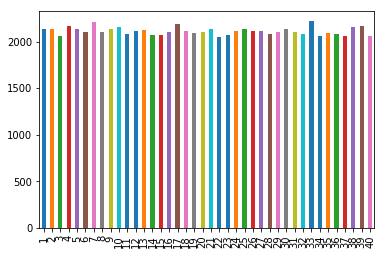

In [18]:
data.V3.value_counts().sort_index().plot(kind='bar')

### Integer data

In [19]:
int_data = train_data.select_dtypes('int').drop(['ID', 'purchase'], axis=1)
int_data.head()

,V1,V4,V5,V6,V7
0,2,1,1,3,2
1,3,2,3,2,2
2,2,1,1,4,2
3,0,2,1,4,2
4,3,1,1,2,2


In [20]:
int_data.describe()

,V1,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,1.500662,1.679608,2.327643,2.502898,1.701694
std,0.868234,0.466630,0.841167,1.117349,0.457517
min,0.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,2.000000,2.000000,1.000000
50%,2.000000,2.000000,2.000000,3.000000,2.000000
75%,2.000000,2.000000,3.000000,4.000000,2.000000
max,3.000000,2.000000,4.000000,4.000000,2.000000


In [21]:
int_data.V1.value_counts()

1    31631
2    31608
3    10670
0    10625
Name: V1, dtype: int64

In [22]:
int_data.V4.value_counts()

2    57450
1    27084
Name: V4, dtype: int64

In [23]:
int_data.V5.value_counts()

3    32743
2    31196
1    15412
4     5183
Name: V5, dtype: int64

In [24]:
int_data.V6.value_counts()

3    21186
4    21176
2    21146
1    21026
Name: V6, dtype: int64

In [25]:
int_data.V7.value_counts()

2    59317
1    25217
Name: V7, dtype: int64

V7 and V1 have a similar distribution...

V6 values seem to be uniformly distributed.

V1 and V5 seem to be less likely in the upper values.

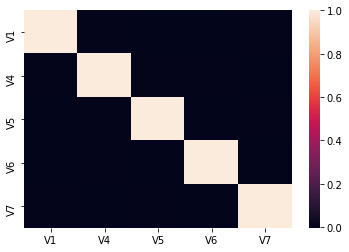

In [26]:
sb.heatmap(int_data.corr())

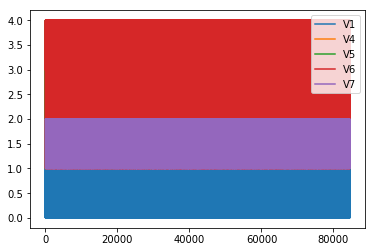

In [27]:
int_data.plot()

In [28]:
data.Promotion = data.Promotion.map({'No': 0, 'Yes':1})

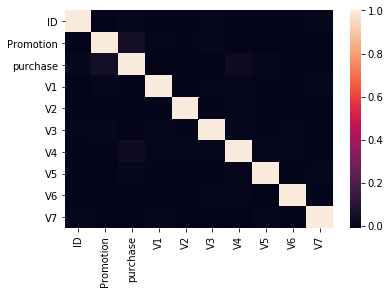

In [29]:
sb.heatmap(data.corr())

There is a slight correlation between the purchases and V4...

The promotion also has a correlation to the purchases.

### Differences between clients that have the Promotion and those who don't

In [36]:
promotion = data[data.Promotion == 1].drop('Promotion', axis=1)
control = data[data.Promotion == 0].drop('Promotion', axis=1)

In [37]:
promotion.head()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
4,8,0,3,28.044332,16,1,1,2,2
8,15,0,2,31.930423,25,2,3,1,2
10,17,0,1,32.770916,3,2,1,4,1
12,20,0,1,36.957009,22,2,3,1,1
14,22,0,3,36.911714,10,2,2,4,1


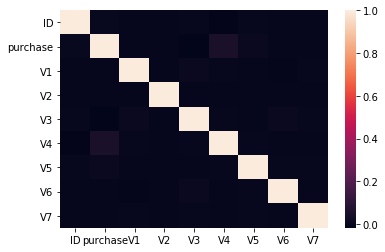

In [38]:
sb.heatmap(promotion.corr())

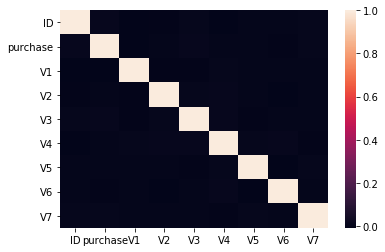

In [40]:
sb.heatmap(control.corr())

It looks like the V4 correlation is stronger when the client was sent a promotion.

## Promotion optimization

In [33]:
data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,0,0,2,30.443518,7,1,1,3,2
1,3,0,0,3,32.159350,13,2,3,2,2
2,4,0,0,2,30.431659,22,1,1,4,2
3,5,0,0,0,26.588914,18,2,1,4,2
4,8,1,0,3,28.044332,16,1,1,2,2


There are 6 ordinal features and only one continuous numeric feature. Using tree methods could be a good idea.

### Analysis

The idea is to maximize the expected IRR and NIR. The formulas are:

$<IRR> = \sum_i P(purch_i|prom_i) \aleph_{prom} - P(purch_i|ctrl_i) (1 - \aleph_{prom})$

(where $\aleph$ is the indicator function)

That means that for each customer, to maximize $<IRR>$, one should choose to send the promotion if and only if: 

$P(purch_i|prom_i) > P(purch_i|ctrl_i) \Rightarrow P(purch_i|prom_i) - P(purch_i|ctrl_i) > 0$

On the other hand:

$<NIR> = \sum_i (10 P(purch_i|prom_i) - 0.15) \aleph_{prom} - 10 P(purch_i|ctrl_i) (1 - \aleph_{prom})$

That means that, to maximize $<NIR>$, one should choose to send the promotion to all those customers that fullfil the condition below:

$10 P(purch_i|prom_i) - 0.15 > 10 P(purch_i|ctrl_i) \Rightarrow P(purch_i|prom_i) - P(purch_i|ctrl_i) > 0.015$

Given those formulas, the only thing missing is to calculate the conditional probabilities:

$P(purch_i|prom_i)$ and $P(purch_i|ctrl_i)$

In particular, the most interesting quantity, for the classification, is their difference:

$d_i = P(purch_i|prom_i) - P(purch_i|ctrl_i)$

To calculate those probabilities, my first two options are:
 - To train two different classifiers (for the prom and ctrl cases)
 - To train only one classifier, containing the "promotion" feature. To calculate the conditional probabilities, the features will be passed with "promotion" in 0 and 1 for each customer.

## First approach: two different classifiers

Note: Some of the features may be categorical, and they could benefit from One-hot encoding if other estimators were being used. For XGboost that is irrelevant.

In [44]:
prom_model = XGBClassifier(max_depth=7, n_estimators=200, n_jobs=-1)
ctrl_model = XGBClassifier(max_depth=7, n_estimators=200, n_jobs=-1)

In [59]:
X_prom = promotion.drop(['ID', 'purchase'], axis=1)
y_prom = promotion.purchase
X_ctrl = control.drop(['ID', 'purchase'], axis=1)
y_ctrl = control.purchase

In [60]:
%time prom_model.fit(X_prom, y_prom)

CPU times: user 7.42 s, sys: 92.9 ms, total: 7.51 s
Wall time: 7.48 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [64]:
%time ctrl_model.fit(X_ctrl, y_ctrl)

CPU times: user 6.93 s, sys: 83.7 ms, total: 7.01 s
Wall time: 6.94 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [65]:
X = pd.concat([X_prom, X_ctrl])
X.shape

(84534, 7)

In [80]:
p_prom = prom_model.predict_proba(X)[:, 1]
p_prom.mean()

0.016835961

In [81]:
p_prom

array([0.00565902, 0.03273445, 0.03088357, ..., 0.01257209, 0.02217016,
       0.00188929], dtype=float32)

In [82]:
p_ctrl = ctrl_model.predict_proba(X)[:, 1]
p_ctrl.mean()

0.007350315

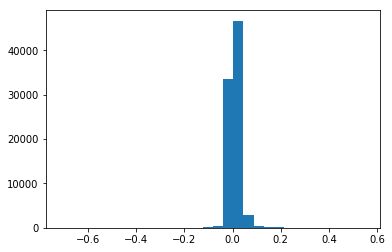

In [84]:
_ = plt.hist(p_prom - p_ctrl, bins=30)

In [86]:
(p_prom - p_ctrl > 0.015).mean()

0.2739844322994298

In [98]:
def promotion_strategy(df, nir=True):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    nir(boolean): If True, optimize the NIR instead of IRR.
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    X = df.copy()
    X.V3 = X.V3.map(v3_encoder)
    
    p_ctrl = ctrl_model.predict_proba(X)[:, 1]
    p_prom = prom_model.predict_proba(X)[:, 1]
    d = p_prom - p_ctrl
    
    threshold = 0.015 if nir else 0.0
    promotion = np.array(['Yes' if irr_i > threshold else 'No'
                          for irr_i in d])
    
    return promotion

In [99]:
res = promotion_strategy(X, nir=True)
(res == 'Yes').mean()

0.5091797383301393

In [100]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0200.

Your nir with this strategy is 275.90.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.020006746842858414, 275.9)

## Second approach: Only one classifier

In [101]:
model = XGBClassifier(max_depth=7, n_estimators=200, n_jobs=-1)

In [104]:
X = data.drop(['ID', 'purchase'], axis=1)
y = data.purchase

In [105]:
X.head()

,Promotion,V1,V2,V3,V4,V5,V6,V7
0,0,2,30.443518,7,1,1,3,2
1,0,3,32.159350,13,2,3,2,2
2,0,2,30.431659,22,1,1,4,2
3,0,0,26.588914,18,2,1,4,2
4,1,3,28.044332,16,1,1,2,2


In [103]:
%time model.fit(X, y)

CPU times: user 16.7 s, sys: 195 ms, total: 16.9 s
Wall time: 17 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [108]:
def promotion_strategy(df, nir=True):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    nir(boolean): If True, optimize the NIR instead of IRR.
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    X = df.copy()
    X.V3 = X.V3.map(v3_encoder)
    
    X_ctrl = X.copy()
    X_prom = X.copy()
    X_ctrl['Promotion'] = np.zeros(X_ctrl.shape[0])
    X_ctrl = X_ctrl[['Promotion', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']] # Reorder columns
    X_prom['Promotion'] = np.ones(X_prom.shape[0])
    X_prom = X_prom[['Promotion', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']] # Reorder columns
    
    p_ctrl = model.predict_proba(X_ctrl)[:, 1]
    p_prom = model.predict_proba(X_prom)[:, 1]
    d = p_prom - p_ctrl
    
    threshold = 0.015 if nir else 0.0
    promotion = np.array(['Yes' if irr_i > threshold else 'No'
                          for irr_i in d])
    
    return promotion

In [109]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0210.

Your nir with this strategy is 311.15.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.021002933230614338, 311.15)

## Grid Search ?